In [1]:
import argparse
import time
import os

import numpy as np

from sklearn.metrics import mean_absolute_error

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torchvision import transforms
from torchvision import models

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from itertools import product
import copy
import pickle

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [3]:
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    torch.set_default_tensor_type('torch.FloatTensor')

In [4]:
def filterLabelsByFrequency(artworks, frequency):
  for column in artworks.filter(regex='labels'):
    label_freq = artworks[column].apply(
        lambda s: [x for x in s]).explode().value_counts().sort_values(ascending=False)

    # Create a list of rare labels
    rare = list(label_freq[label_freq < frequency].index)

    artworks[column] = artworks[column].apply(
        lambda s: [x for x in s if x not in rare])
    artworks[column] = artworks[column].apply(
        lambda s: s if len(s) != 0 else np.nan)

  artworks.dropna(inplace=True)
  return artworks

In [5]:
with open("test", "rb") as file:
    artworks = pickle.load(file)

In [6]:
# with open("artworks", "rb") as file:
#     artworks = pickle.load(file)

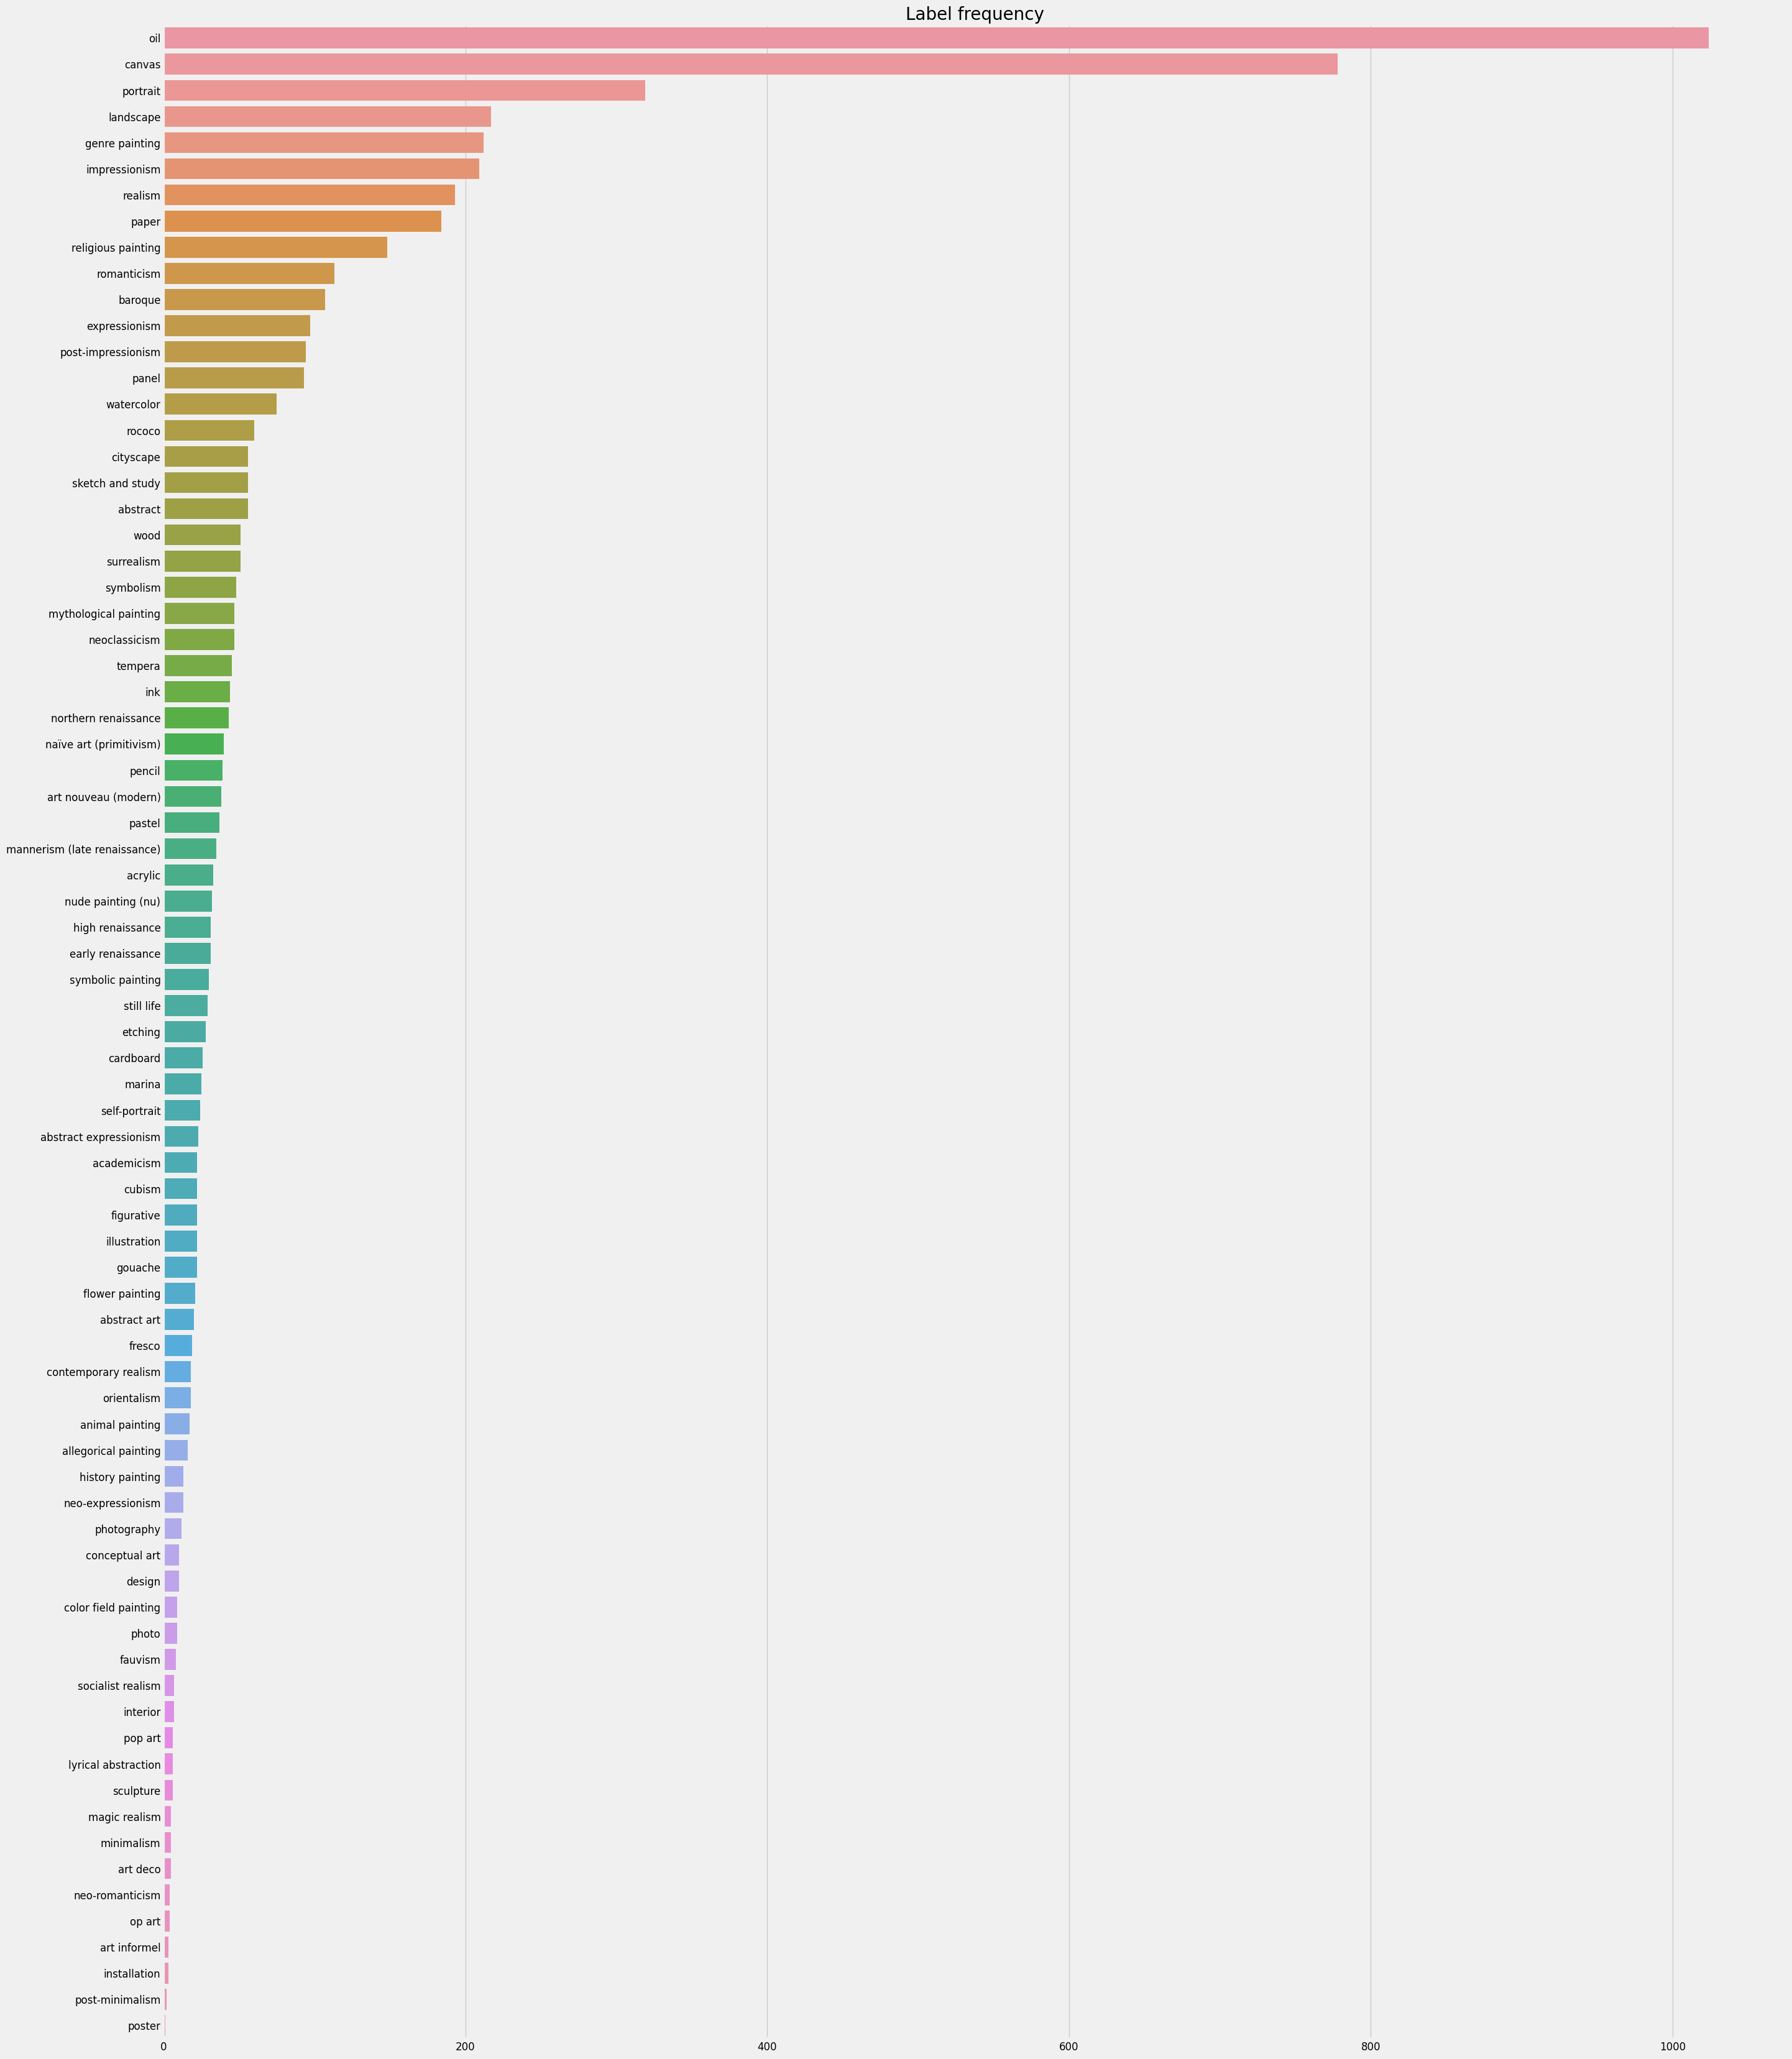

In [7]:
artworks = filterLabelsByFrequency(artworks, 25)

object_label_freq = artworks['object_labels'].apply(
    lambda s: [x for x in s]).explode().value_counts()
style_label_freq = artworks['style_labels'].apply(
    lambda s: [x for x in s]).explode().value_counts()
material_label_freq = artworks['material_labels'].apply(
    lambda s: [x for x in s]).explode().value_counts()

label_freq = pd.concat([object_label_freq, style_label_freq,
                       material_label_freq]).sort_values(ascending=False)

style.use("fivethirtyeight")
plt.figure(figsize=(30, 40))
sns.barplot(y=label_freq.index.values, x=label_freq, order=label_freq.index)
plt.title("Label frequency", fontsize=20)
plt.xlabel("")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [8]:
def count_labels(label_list):
    total_labels = []
    for labels in label_list:
      labels = list(filter(None, labels))
      total_labels.extend(labels)

    return len(list(set(total_labels))), list(set(total_labels))


def get_index_of_np(numpy, val):
  index_np = np.where(numpy == val)[0]

  if index_np.size != 1:
    print('a', index_np[0], index_np.size, val)
    return None
  else:
    return index_np[0]
  
def get_adjacency_matrix(artwork_labels_list, total_labels, N_LABEL):
  adjacency_matrix = np.zeros((N_LABEL, N_LABEL))
  
  for artwork_labels in artwork_labels_list:
    label_combinations = list(product(artwork_labels, repeat=2))
    
    for label_combination in label_combinations:
      pivot_index = get_index_of_np(total_labels, label_combination[0])
      target_index = get_index_of_np(total_labels, label_combination[1])
      if (pivot_index is None) or (target_index is None):
        return None
      else:
        adjacency_matrix[pivot_index][target_index] += 1

  for row_index, row in enumerate(adjacency_matrix):
    basis = row[row_index]
    for col_index, val in enumerate(row):
      row[col_index] = val/basis
    
  return adjacency_matrix

def convert_to_graph(artworks):
  label_classes = ['object_labels', 'style_labels', 'material_labels']
  artwork_labels_list=[]
  labels_list_by_class = [set() for _ in range(3)]

  for index, label_class in enumerate(label_classes):
    labels_group = artworks[label_class]

    if index == 0:
      for labels in labels_group:
        artwork_labels_list.append(copy.deepcopy(labels))
        labels_list_by_class[index] = labels_list_by_class[index].union(set(copy.deepcopy(labels)))
    else:
      for i, labels in enumerate(labels_group):
        artwork_labels_list[i].extend(copy.deepcopy(labels))
        labels_list_by_class[index] = labels_list_by_class[index].union(
            set(copy.deepcopy(labels)))
  
  N_LABEL, total_labels = count_labels(artwork_labels_list)
  adjacency_matrix = get_adjacency_matrix(
      artwork_labels_list, np.array(total_labels), N_LABEL)
  
  class_one_hot_encoding_matrix = np.zeros((N_LABEL, 3))

  for i in range(N_LABEL):
    label = total_labels[i]
    for j in range(3):
      class_one_hot_encoding_matrix[i][j] = np.any(
          np.array(list(labels_list_by_class[j])) == label)
  
  embedding = nn.Embedding(N_LABEL, embedding_dim=5)
  input = torch.tensor(range(len(total_labels)))
  word_embedding_matrix = embedding(input).detach().cpu().numpy()
  
  feature_matrix = np.concatenate((class_one_hot_encoding_matrix, word_embedding_matrix), axis=1)
  
  return adjacency_matrix, feature_matrix, N_LABEL, total_labels


In [9]:
adjacency_matrix, feature_matrix, N_LABEL, total_labels = convert_to_graph(
    artworks)

In [10]:
feature_matrix_tensor = torch.Tensor(
    feature_matrix).to(torch.float32).to(device)
adjacency_matrix_tensor = torch.Tensor(
    adjacency_matrix).to(torch.float32).to(device)
degree_matrix_tensor = torch.diag(torch.sum(adjacency_matrix_tensor, dim=1))
laplacian_matrix_tensor = degree_matrix_tensor - adjacency_matrix_tensor


In [11]:
# root_path = './database_all'
root_path = './database_test'

In [12]:
artworks['labels'] = artworks['object_labels'] + artworks['style_labels'] + artworks['material_labels']

dataset_size = len(artworks)
train_size = int(dataset_size * 0.8)
validation_size = int(dataset_size * 0.2)
test_size = int(validation_size * 0.5)

X_train, X_val, y_train, y_val = train_test_split(
    artworks['File'], artworks['labels'], test_size=0.2, random_state=23)
X_val, X_test, y_val, y_test = train_test_split(
    X_val, y_val, test_size=0.5, random_state=23)

X_train = [os.path.join(root_path, str(f)) for f in X_train]
X_val = [os.path.join(root_path, str(f)) for f in X_val]
X_test = [os.path.join(root_path, str(f)) for f in X_test]

label_list = pd.DataFrame({'labels': [total_labels]})
mlb = MultiLabelBinarizer()
mlb.fit(label_list['labels'])

y_train = list(y_train)
y_val = list(y_val)
y_test = list(y_test)
y_train_bin = mlb.transform(y_train).astype(np.float64)
y_val_bin = mlb.transform(y_val).astype(np.float64)
y_test_bin = mlb.transform(y_test).astype(np.float64)

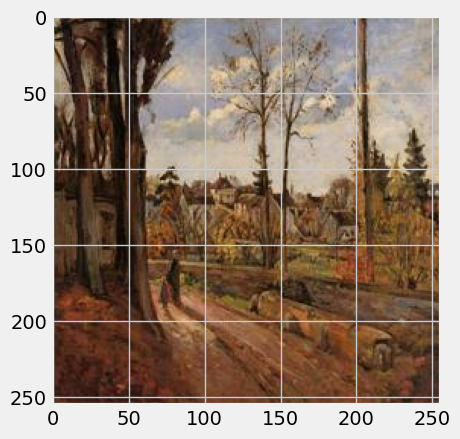

In [13]:
from PIL import Image
sample_image = Image.open(X_train[0])
plt.imshow(sample_image, cmap='gray')


In [14]:
class ArtworksDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        img = Image.open(self.X[index]).convert('RGB')
        label = torch.tensor(self.y[index], dtype=torch.float32)

        if self.transform:
            img = self.transform(img)

        return img, label


In [15]:
def get_dataloader(X, y, batch_size, mode='train'):
    if mode == 'train':
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ])
    else:
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
        ])

    dataset = ArtworksDataset(X, y, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size,
                            shuffle=True, generator=torch.Generator(device=device))
    total_batch = dataset.__len__() // batch_size
    return dataloader, total_batch


In [16]:
class AttentionModule(nn.Module):
  def __init__(self, in_dim, out_dim, head_num):
    super(AttentionModule, self).__init__()

    self.head_num = head_num
    self.attention_dim = out_dim // head_num

    self.linears = nn.ModuleList()
    self.correlations = nn.ParameterList()
    for i in range(self.head_num):
      self.linears.append(nn.Linear(in_dim, self.attention_dim))
      correlation = torch.FloatTensor(self.attention_dim, self.attention_dim).to(device)
      nn.init.xavier_uniform_(correlation)
      self.correlations.append(nn.Parameter(correlation))
    
    self.tanh = nn.Tanh()
    self.set_out_dim = nn.Linear(head_num * self.attention_dim, out_dim)
  
  def forward(self, x, adj):
    heads = list()
    for i in range(self.head_num):
      x_i = self.linears[i](x)
      alpha = self.attention_matrix(x_i, self.correlations[i], adj)
      x_head = torch.matmul(alpha, x_i)
      heads.append(x_head)
    out = torch.cat(heads, dim=1)
    out = self.set_out_dim(out)
    return out
  
  def attention_matrix(self, x_i, correlation, adj):
    x = torch.matmul(x_i, correlation)
    alpha = torch.matmul(x, torch.transpose(x_i, 0, 1))
    alpha = torch.mul(alpha, adj)
    alpha = self.tanh(alpha)
    return alpha
      

In [17]:
# class GCNLayer(nn.Module):
#   def __init__(self, in_dim, out_dim, act=None, atn=False, head_num=1, drop_rate=0):
#     super(GCNLayer, self).__init__()

#     self.linear = nn.Linear(in_dim, out_dim)
#     nn.init.xavier_uniform(self.linear.weight)
#     self.activation = act
#     self.use_attention = atn
#     self.attention = AttentionModule(out_dim, out_dim, head_num)
#     self.drop_rate = drop_rate
#     self.dropout = nn.Dropout(self.drop_rate)

#   def forward(self, x, adj):
#     out = self.linear(x)
#     if self.use_attention:
#       out = self.attention(out, adj)
#     out = torch.matmul(adj, out)
#     if self.activation != None:
#       out = self.activation(out)
#     if self.drop_rate > 0:
#       out = self.dropout(out)

#     return out, adj

In [18]:
class GCNLayer(nn.Module):
  def __init__(self, in_dim, out_dim, act=None, atn=False, head_num=1, drop_rate=0):
    super(GCNLayer, self).__init__()

    self.linear = nn.Linear(in_dim, out_dim)
    nn.init.xavier_uniform(self.linear.weight)
    self.activation = act
    self.use_attention = atn
    self.attention = AttentionModule(out_dim, out_dim, head_num)
    self.drop_rate = drop_rate
    self.dropout = nn.Dropout(self.drop_rate)
    # self.layer_norm = nn.LayerNorm(out_dim)

  def forward(self, x, lapl):
    out = self.linear(x)
    if self.use_attention:
      out = self.attention(out, lapl)
    out = torch.matmul(lapl, out)
    if self.activation != None:
      out = self.activation(out)
    if self.drop_rate > 0:
      out = self.dropout(out)
    # out = self.layer_norm(out)
    return out, lapl


In [19]:
class GatedSkipConnection(nn.Module):
  def __init__(self, in_dim, out_dim):
    super(GatedSkipConnection, self).__init__()

    self.in_dim = in_dim
    self.out_dim = out_dim

    self.linear = nn.Linear(in_dim, out_dim, bias=False)
    self.linear_coef_in = nn.Linear(out_dim, out_dim)
    self.linear_coef_out = nn.Linear(out_dim, out_dim)
    self.sigmoid = nn.Sigmoid()

  def forward(self, in_x, out_x):
    if (self.in_dim != self.out_dim):
        in_x = self.linear(in_x)
    z = self.gate_coefficient(in_x, out_x)
    out = torch.mul(z, out_x) + torch.mul(1.0-z, in_x)
    return out

  def gate_coefficient(self, in_x, out_x):
    x1 = self.linear_coef_in(in_x)
    x2 = self.linear_coef_out(out_x)
    return self.sigmoid(x1+x2)

In [20]:
class GCNBlock(nn.Module):
  def __init__(self, n_layer, in_dim, hidden_dim, out_dim, sc='gsc', atn=True, head_num=1, drop_rate=0):
    super(GCNBlock, self).__init__()

    self.layers = nn.ModuleList()
    for i in range(n_layer):
        self.layers.append(GCNLayer(in_dim if i == 0 else hidden_dim,
                                    out_dim if i == n_layer-1 else hidden_dim,
                                    None,
                                    atn,
                                    head_num,
                                    drop_rate))
    # self.relu = nn.ReLU()
    if sc == 'gsc':
        self.sc = GatedSkipConnection(in_dim, out_dim)
    elif sc == 'no':
        self.sc = None
    else:
        assert False, "Wrong sc type."

  def forward(self, x, lapl):
    residual = x
    out = None
    for i, layer in enumerate(self.layers):
        out, lapl = layer((x if i == 0 else out), lapl)
    if self.sc != None:
        out = self.sc(residual, out)
    # out = self.relu(out)
    return out, lapl


In [21]:
class InceptionModule(nn.Module):
  def __init__(self, n_layer, in_dim, hidden_dim, out_dim, sc='gsc', atn=True, head_num=1, drop_rate=0):
    super(InceptionModule, self).__init__()
    self.GCNBlocks = nn.ModuleList()
    for i in range(n_layer):
      self.GCNBlocks.append(GCNBlock(i + 1,
                                    in_dim,
                                    hidden_dim,
                                    out_dim,
                                    sc,
                                    atn,
                                    head_num,
                                    drop_rate))

  def forward(self, x, lapl):
    outs = []
    for i, block in enumerate(self.GCNBlocks):
      out, _ = block(x, lapl)
      outs.append(out)

    feature_concatenate = torch.cat(outs, 1)
    return feature_concatenate, lapl


In [22]:
class ReadOut(nn.Module):

    def __init__(self, in_dim, out_dim, act=None):
        super(ReadOut, self).__init__()

        self.in_dim = in_dim
        self.out_dim = out_dim

        self.linear = nn.Linear(self.in_dim,
                                self.out_dim)
        nn.init.xavier_uniform_(self.linear.weight)
        self.activation = act

    def forward(self, x):
        out = self.linear(x)
        # out = torch.sum(out, 1)
        if self.activation != None:
            out = self.activation(out)
        return out

In [23]:
class GCNNet(nn.Module):
  def __init__(self, args):
    super(GCNNet, self).__init__()

    self.InceptionModule = InceptionModule(args.n_layer,
                                           args.in_dim,
                                           args.hidden_dim,
                                           args.out_dim,
                                           args.sc,
                                           args.atn,
                                           args.head_num,
                                           args.drop_rate)
    self.Readout = ReadOut(args.out_dim * args.n_layer,
                           args.out_dim, None)

  def forward(self, x, lapl):
    out, _ = self.InceptionModule(x, lapl)
    out = self.Readout(out)

    return out


In [24]:
# Define the model architecture
class Resnet50(nn.Module):
    def __init__(self, n_label):
        super(Resnet50, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(num_ftrs, n_label)
        )

    def forward(self, x):
        x = self.resnet(x)
        return x


In [25]:
class Resnet50_2(nn.Module):
	def __init__(self, out_dim):
		super(Resnet50_2, self).__init__()
		self.resnet = models.resnet50(pretrained=True)
		num_ftrs = self.resnet.fc.in_features
		self.resnet.fc = nn.Sequential(
				nn.Dropout(p=0.5),
				nn.Linear(num_ftrs, out_dim)
		)

	def forward(self, x):
		x = self.resnet(x)
		return x


In [26]:
class CNNGCN(nn.Module):
  def __init__(self, n_label, args):
    super(CNNGCN, self).__init__()
    self.Resnet50 = Resnet50_2(args.out_dim)
    self.GCNNet = GCNNet(args)
    # self.linear = nn.Linear(args.n_label, args.n_label)
    # nn.init.xavier_uniform_(self.linear.weight)

  def forward(self, x1, x2, lapl):
    out1 = self.Resnet50(x1)
    out2 = self.GCNNet(x2, lapl)
    # out2 = out2.unsqueeze(0)
    out = torch.mm(out1, out2.t())
    # out = self.linear(out)
    return out


In [27]:
def multi_label_metrics(y_true, y_pred):
    """
    다중 레이블 분류 문제에서 Precision, recall, F1 score 계산 함수
    
    Args:
        y_true (torch.Tensor): 정답 레이블. shape: (batch_size, num_classes)
        y_pred (torch.Tensor): 모델 예측 레이블. shape: (batch_size, num_classes)
        
    Returns:
        precision (float): Precision 값
        recall (float): Recall 값
        f1_score (float): F1 Score 값
    """
    true_positives = torch.sum((y_true == 1) & (y_pred == 1), dim=0)
    false_positives = torch.sum((y_true == 0) & (y_pred == 1), dim=0)
    false_negatives = torch.sum((y_true == 1) & (y_pred == 0), dim=0)

    precision = torch.mean(
        true_positives / (true_positives + false_positives + 1e-8))
    recall = torch.mean(
        true_positives / (true_positives + false_negatives + 1e-8))
    f1_score = 2 * ((precision * recall) / (precision + recall + 1e-8))

    return precision.item(), recall.item(), f1_score.item()


In [28]:
def train(model, criterion, optimizer, batch_size, scheduler, num_epochs):
    train_loader, train_total_batch = get_dataloader(
        X_train, y_train_bin, batch_size, 'train')
    val_loader, val_total_batch = get_dataloader(
        X_val, y_val_bin, batch_size, 'val')
    
    train_precision_list = []
    train_recall_list = []
    train_f1_list = []
    train_loss_list = []
    val_precision_list = []
    val_recall_list = []
    val_f1_list = []
    val_loss_list = []
    best_val_loss = float('inf')
    patience = 0  # early stopping 관련 변수
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        total_predictions = []
        total_labels = []

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # 모델에 입력값 전달
            outputs = model(inputs)

            # 손실 계산
            loss = criterion(outputs, labels)

            # 기울기 초기화, 역전파, optimizer 업데이트
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # 예측값 계산
            predictions = torch.sigmoid(outputs) >= 0.5

            # 손실계산
            running_loss += loss.item() * inputs.size(0)
            total_predictions += predictions.tolist()
            total_labels += labels.tolist()
            
        scheduler.step()

        # 에폭별 손실과 정확도
        epoch_loss = running_loss / len(train_loader.dataset)
        train_precision, train_recall, train_f1_score = multi_label_metrics(
            torch.tensor(total_labels), torch.tensor(total_predictions))
        
        train_precision_list.append(train_precision)
        train_recall_list.append(train_recall)
        train_f1_list.append(train_f1_score)
        train_loss_list.append(epoch_loss)
        
        # validation set에서 모델 평가
        model.eval()
        val_running_loss = 0.0
        val_total_predictions = []
        val_total_labels = []
        
        for val_inputs, val_labels in val_loader:
            val_inputs = val_inputs.to(device)
            val_labels = val_labels.to(device)

            # 모델에 입력값 전달
            val_outputs = model(val_inputs)

            # 손실 계산
            val_loss = criterion(val_outputs, val_labels)

            # 예측값 계산
            val_prediction = torch.sigmoid(val_outputs) >= 0.5

            # 정확도 계산
            val_running_loss += val_loss.item() * val_inputs.size(0)
            val_total_predictions += val_prediction.tolist()
            val_total_labels += val_labels.tolist()

        # 에폭별 손실과 정확도
        val_epoch_loss = val_running_loss / len(val_loader.dataset)
        val_precision, val_recall, val_f1_score = multi_label_metrics(
            torch.tensor(val_total_labels), torch.tensor(val_total_predictions))
        
        val_precision_list.append(val_precision)
        val_recall_list.append(val_recall)
        val_f1_list.append(val_f1_score)
        val_loss_list.append(val_epoch_loss)

        print('Epoch [{}/{}], train_loss: {:.4f}, train_precision: {:.4f}, train_recall: {:.4f}, train_f1_score: {:.4f}\nval_loss: {:.4f}, val_precision: {:.4f}, val_recall: {:.4f}, val_f1_score: {:.4f}'
              .format(epoch+1, num_epochs, epoch_loss, train_precision, train_recall, train_f1_score, val_epoch_loss, val_precision, val_recall, val_f1_score))
        
        # early stopping 적용
        if val_epoch_loss < best_val_loss:
            best_val_loss = val_epoch_loss
        else:
            if patience > 5:
                break
            patience += 1
    return model, train_loss_list, train_precision_list, train_recall_list, train_f1_list, val_loss_list, val_precision_list, val_recall_list, val_f1_list


In [29]:
# Define the model, optimizer and loss function
model_resnet = Resnet50(N_LABEL).to(device)
optimizer_ft = optim.Adam(model_resnet.parameters(), lr=0.001)
exp_lr_scheduler = optim.lr_scheduler.StepLR(
    optimizer_ft, step_size=7, gamma=0.1)
criterion = nn.MultiLabelSoftMarginLoss()

# Train the model
model_resnet, train_loss, train_precision, train_recall, train_f1, val_loss, val_precision, val_recall, val_f1 = train(
    model_resnet, criterion, optimizer_ft, 32, exp_lr_scheduler, 25)


C:\Users\이성준\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\이성준\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/25], train_loss: 0.1704, train_precision: 0.0671, train_recall: 0.0406, train_f1_score: 0.0506
val_loss: 0.1406, val_precision: 0.0395, val_recall: 0.0314, val_f1_score: 0.0350
Epoch [2/25], train_loss: 0.1337, train_precision: 0.0656, train_recall: 0.0301, train_f1_score: 0.0413
val_loss: 0.1367, val_precision: 0.0735, val_recall: 0.0300, val_f1_score: 0.0426
Epoch [3/25], train_loss: 0.1306, train_precision: 0.0561, train_recall: 0.0329, train_f1_score: 0.0415
val_loss: 0.3199, val_precision: 0.0315, val_recall: 0.0240, val_f1_score: 0.0273
Epoch [4/25], train_loss: 0.1276, train_precision: 0.0943, train_recall: 0.0393, train_f1_score: 0.0555
val_loss: 0.1626, val_precision: 0.0625, val_recall: 0.0380, val_f1_score: 0.0472
Epoch [5/25], train_loss: 0.1256, train_precision: 0.0812, train_recall: 0.0386, train_f1_score: 0.0523
val_loss: 0.1425, val_precision: 0.0587, val_recall: 0.0296, val_f1_score: 0.0394
Epoch [6/25], train_loss: 0.1235, train_precision: 0.0997, train_recal

In [60]:
import pickle
model_path = './models/'
torch.save(model_resnet.state_dict(), model_path + 'resnet50-epoch100.pt')

with open("resnet50_train_loss.pickle", "wb") as f:
    pickle.dump(train_loss, f)
with open("resnet50_train_precision.pickle", "wb") as f:
    pickle.dump(train_precision, f)
with open("resnet50_train_recall.pickle", "wb") as f:
    pickle.dump(train_recall, f)
with open("resnet50_train_f1s.pickle", "wb") as f:
    pickle.dump(train_f1, f)

with open("resnet50_val_loss.pickle", "wb") as f:
    pickle.dump(val_loss, f)
with open("resnet50_val_precision.pickle", "wb") as f:
    pickle.dump(val_precision, f)
with open("resnet50_val_recall.pickle", "wb") as f:
    pickle.dump(val_recall, f)
with open("resnet50_val_f1s.pickle", "wb") as f:
    pickle.dump(val_f1, f)


In [40]:
import torch_geometric
from torch_geometric.nn import GCNConv

paser = argparse.ArgumentParser()
args = paser.parse_args("")
args.n_layer = 10
args.in_dim = 8
args.hidden_dim = 10
args.out_dim = 10
args.sc = 'gsc'
args.n_label = N_LABEL
args.act = nn.PReLU()
args.atn = True
args.head_num = 1
args.drop_rate = 0.5

model_resnet_test = Resnet50_2(N_LABEL)
model_gcnnet_test = GCNNet(args)
model = CNNGCN(N_LABEL, args)

train_loader, train_total_batch = get_dataloader(
    X_train, y_train_bin, 4, 'train')
criterion = nn.BCEWithLogitsLoss()

for inputs, labels in train_loader:
	inputs = inputs.to(torch.float32).to(device)
	labels = labels.to(device)
	
	out1 = model_resnet_test(inputs)
	out2 = model_gcnnet_test(feature_matrix_tensor, laplacian_matrix_tensor)
	print(out1.shape)
	print(out2.shape)
	# torch.mm(out1, out.t())
	out, out1, out2 = model(inputs, feature_matrix_tensor, laplacian_matrix_tensor)
	print(out.shape)
	print(out1.shape)
	print(out2.shape)
	# print(inputs.size(0))
	# print(loss)
	break


C:\Users\이성준\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\이성준\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\이성준\AppData\Local\Temp\ipykernel_24128\2127708053.py:6: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(self.linear.weight)


torch.Size([4, 8])
torch.Size([8, 10])
torch.Size([4, 8])
torch.Size([4, 10])
torch.Size([8, 10])


In [ ]:
plt.figure(figsize=(12, 12))
x = range(len(train_loss))
y = train_loss
plt.plot(x, y)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('train loss')
plt.show()

In [ ]:
plt.figure(figsize=(12, 12))
x = range(len(train_precision))
y = train_precision
plt.plot(x, y, color='red')
plt.xlabel('epoch')
plt.ylabel('precision')
plt.title('train_precision')
plt.show()

In [ ]:
plt.figure(figsize=(12, 12))
x = range(len(train_recall))
y = train_recall
plt.plot(x, y, color='green')
plt.xlabel('epoch')
plt.ylabel('recall')
plt.title('train_recall')
plt.show()

In [ ]:
plt.figure(figsize=(12, 12))
x = range(len(train_f1))
y = train_f1
plt.plot(x, y, color='orange')
plt.xlabel('epoch')
plt.ylabel('f1_score')
plt.title('train_f1')
plt.show()

In [30]:
def train_cnngcn(model, criterion, optimizer, batch_size, scheduler, num_epochs):
    train_loader, train_total_batch = get_dataloader(
        X_train, y_train_bin, batch_size, 'train')
    val_loader, val_total_batch = get_dataloader(
        X_val, y_val_bin, batch_size, 'val')

    train_precision_list = []
    train_recall_list = []
    train_f1_list = []
    train_loss_list = []
    val_precision_list = []
    val_recall_list = []
    val_f1_list = []
    val_loss_list = []
    best_val_loss = float('inf')
    patience = 0  # early stopping 관련 변수

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        total_predictions = []
        total_labels = []
        
        i = 0
        for inputs, labels in train_loader:
            inputs = inputs.to(torch.float32).to(device)
            labels = labels.to(device)
        
            # 모델에 입력값 전달
            outputs = model(inputs, feature_matrix_tensor,
                            laplacian_matrix_tensor)

            # 손실 계산
            loss = criterion(outputs, labels)

            # 기울기 초기화, 역전파, optimizer 업데이트
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # 예측값 계산
            predictions = torch.sigmoid(outputs) >= 0.5

            i += 1
            # 손실계산
            running_loss += loss.item() * inputs.size(0)
            total_predictions += predictions.tolist()
            total_labels += labels.tolist()

        scheduler.step()

        # 에폭별 손실과 정확도
        # print('dataset length: {}'.format(len(train_loader.dataset)))
        epoch_loss = running_loss / len(train_loader.dataset)
        train_precision, train_recall, train_f1_score = multi_label_metrics(
            torch.tensor(total_labels), torch.tensor(total_predictions))

        train_precision_list.append(train_precision)
        train_recall_list.append(train_recall)
        train_f1_list.append(train_f1_score)
        train_loss_list.append(epoch_loss)

        # validation set에서 모델 평가
        model.eval()

        val_running_loss = 0.0
        val_total_predictions = []
        val_total_labels = []

        for val_inputs, val_labels in val_loader:
            val_inputs = val_inputs.to(torch.float32).to(device)
            val_labels = val_labels.to(device)

            # 모델에 입력값 전달
            val_outputs = model(
                val_inputs, feature_matrix_tensor, laplacian_matrix_tensor)

            # 손실 계산
            val_loss = criterion(val_outputs, val_labels)

            # 예측값 계산
            val_prediction = torch.sigmoid(val_outputs) >= 0.5

            # 정확도 계산
            val_running_loss += val_loss.item() * val_inputs.size(0)
            val_total_predictions += val_prediction.tolist()
            val_total_labels += val_labels.tolist()

        # 에폭별 손실과 정확도
        val_epoch_loss = val_running_loss / len(val_loader.dataset)
        val_precision, val_recall, val_f1_score = multi_label_metrics(
            torch.tensor(val_total_labels), torch.tensor(val_total_predictions))

        val_precision_list.append(val_precision)
        val_recall_list.append(val_recall)
        val_f1_list.append(val_f1_score)
        val_loss_list.append(val_epoch_loss)

        print('Epoch [{}/{}], train_loss: {:.4f}, train_precision: {:.4f}, train_recall: {:.4f}, train_f1_score: {:.4f}\nval_loss: {:.4f}, val_precision: {:.4f}, val_recall: {:.4f}, val_f1_score: {:.4f}'
              .format(epoch+1, num_epochs, epoch_loss, train_precision, train_recall, train_f1_score, val_epoch_loss, val_precision, val_recall, val_f1_score))

        # early stopping 적용
        if val_epoch_loss < best_val_loss:
            best_val_loss = val_epoch_loss
        else:
            if patience > 5:
                break
            patience += 1
    return model, train_loss_list, train_precision_list, train_recall_list, train_f1_list, val_loss_list, val_precision_list, val_recall_list, val_f1_list


In [31]:
paser = argparse.ArgumentParser()
args = paser.parse_args("")
args.n_layer = 1
args.in_dim = 8
args.hidden_dim = 5
args.out_dim = 5
args.sc = 'no'
args.n_label = N_LABEL
args.act = None
args.atn = True
args.head_num = 2
args.drop_rate = 0
model_cnngcn = CNNGCN(N_LABEL, args).to(device)

optimizer_ft = optim.Adam(model_cnngcn.parameters(), lr=0.001)
exp_lr_scheduler = optim.lr_scheduler.StepLR(
    optimizer_ft, step_size=7, gamma=0.1)
# criterion = nn.MultiLabelSoftMarginLoss()
criterion = nn.BCEWithLogitsLoss()

# Train the model
model_cnngcn, train_loss_2, train_precision_2, train_recall_2, train_f1_2, val_loss_2, val_precision_2, val_recall_2, val_f1_2 = train_cnngcn(
    model_cnngcn, criterion, optimizer_ft, 32, exp_lr_scheduler, 100)
# model_cnngcn, train_loss_2, train_precision_2, train_recall_2, train_f1_2 = train_cnngcn(model_cnngcn, criterion, optimizer_ft, 32, exp_lr_scheduler, 1)


C:\Users\이성준\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\이성준\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\이성준\AppData\Local\Temp\ipykernel_9592\1168380658.py:6: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(self.linear.weight)


Epoch [1/100], train_loss: 0.3825, train_precision: 0.0504, train_recall: 0.0916, train_f1_score: 0.0650
val_loss: 0.1956, val_precision: 0.0000, val_recall: 0.0000, val_f1_score: 0.0000
Epoch [2/100], train_loss: 0.1800, train_precision: 0.0294, train_recall: 0.0008, train_f1_score: 0.0015
val_loss: 0.1700, val_precision: 0.0000, val_recall: 0.0000, val_f1_score: 0.0000
Epoch [3/100], train_loss: 0.1722, train_precision: 0.0231, train_recall: 0.0036, train_f1_score: 0.0062
val_loss: 0.1633, val_precision: 0.0130, val_recall: 0.0002, val_f1_score: 0.0005
Epoch [4/100], train_loss: 0.1666, train_precision: 0.0267, train_recall: 0.0072, train_f1_score: 0.0113
val_loss: 0.1601, val_precision: 0.0123, val_recall: 0.0021, val_f1_score: 0.0036
Epoch [5/100], train_loss: 0.1632, train_precision: 0.0286, train_recall: 0.0111, train_f1_score: 0.0160
val_loss: 0.1565, val_precision: 0.0250, val_recall: 0.0083, val_f1_score: 0.0125
Epoch [6/100], train_loss: 0.1604, train_precision: 0.0277, train

KeyboardInterrupt: 

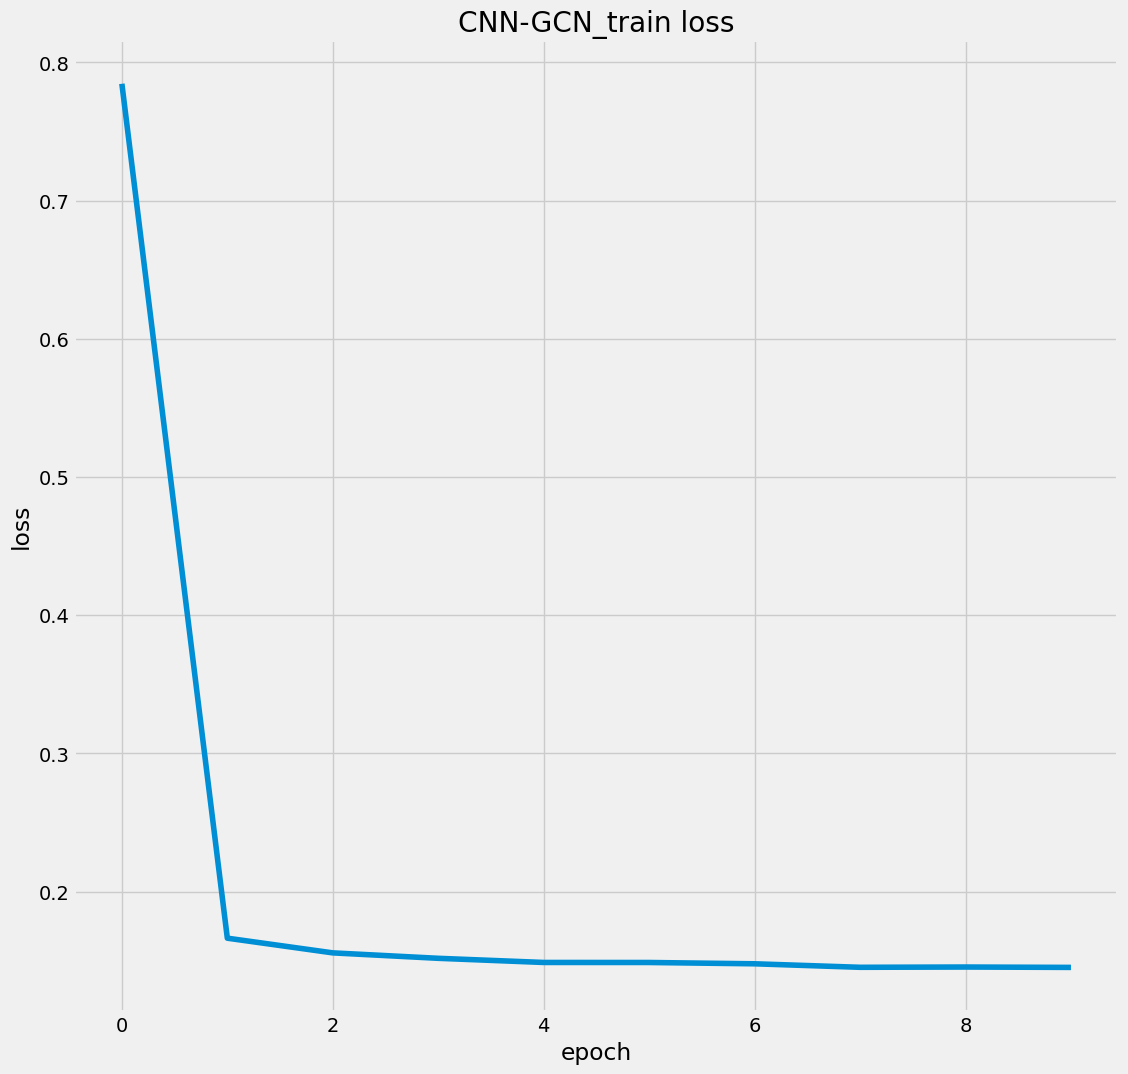

In [33]:
plt.figure(figsize=(12, 12))
x = range(len(train_loss_2))
y = train_loss_2
plt.plot(x, y)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('CNN-GCN_train loss')
plt.show()

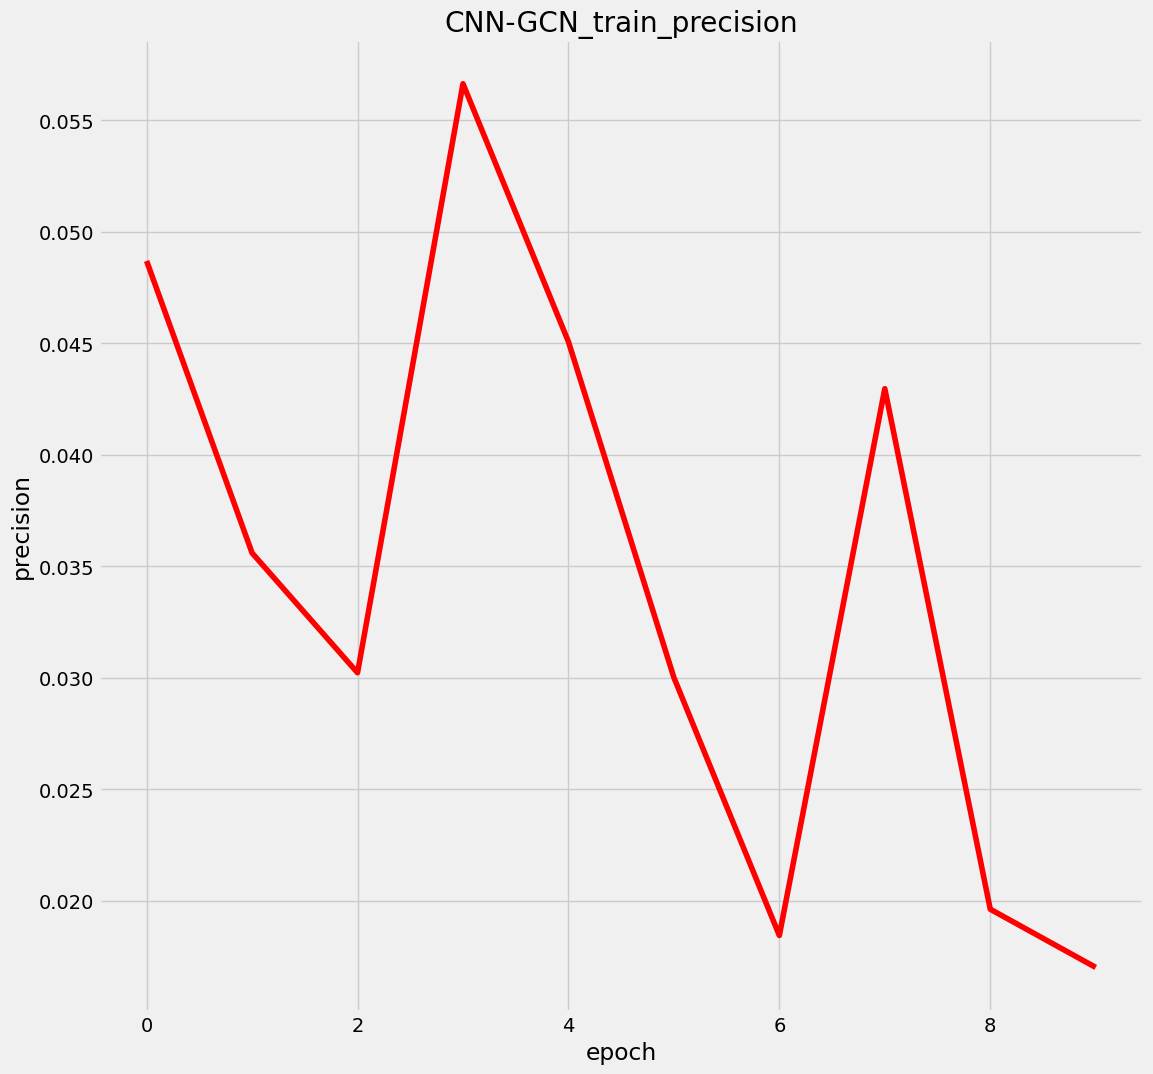

In [34]:
plt.figure(figsize=(12, 12))
x = range(len(train_precision_2))
y = train_precision_2
plt.plot(x, y, color='red')
plt.xlabel('epoch')
plt.ylabel('precision')
plt.title('CNN-GCN_train_precision')
plt.show()

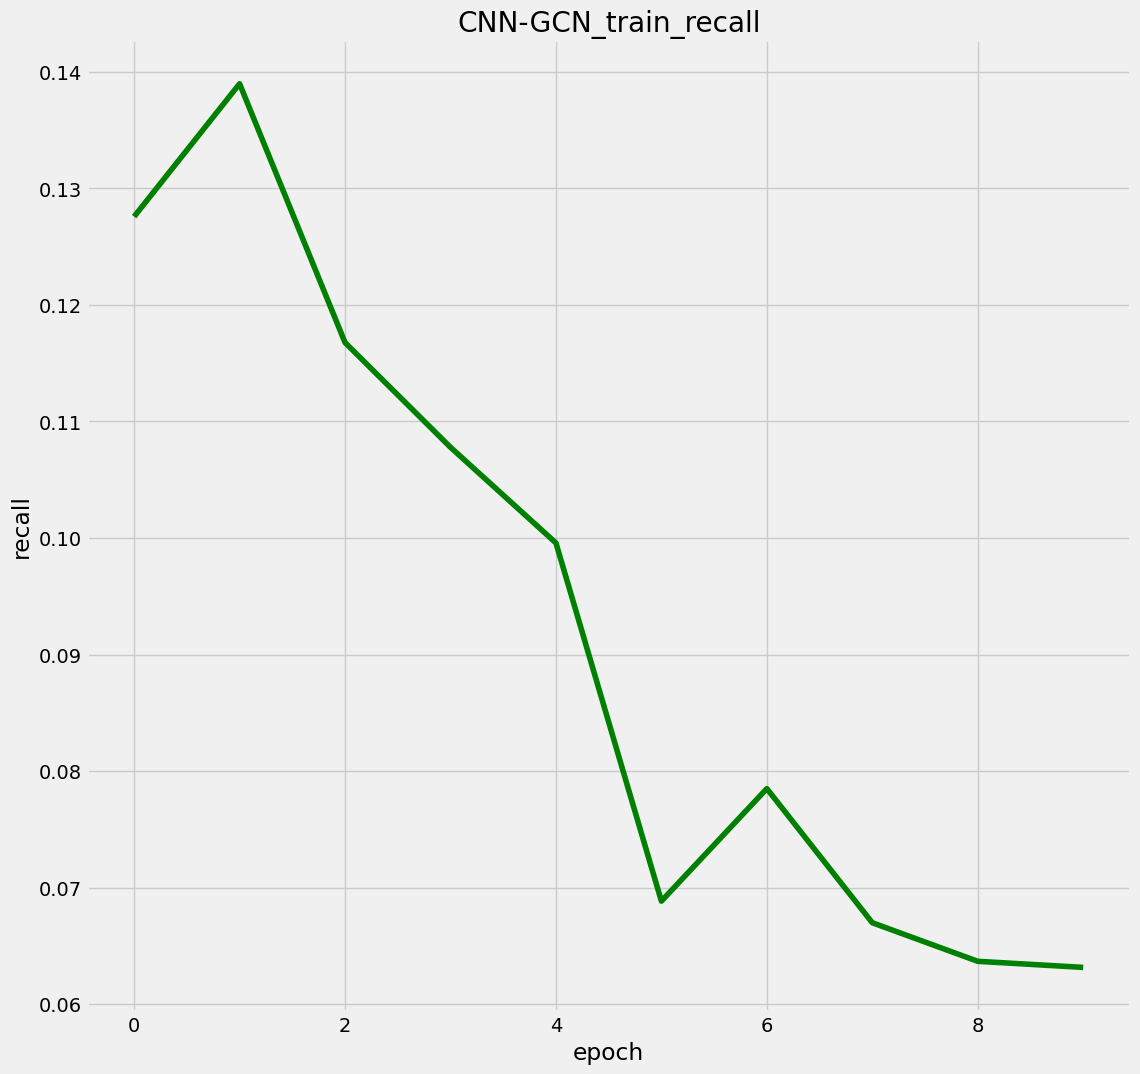

In [30]:
plt.figure(figsize=(12, 12))
x = range(len(train_recall_2))
y = train_recall_2
plt.plot(x, y, color='green')
plt.xlabel('epoch')
plt.ylabel('recall')
plt.title('CNN-GCN_train_recall')
plt.show()

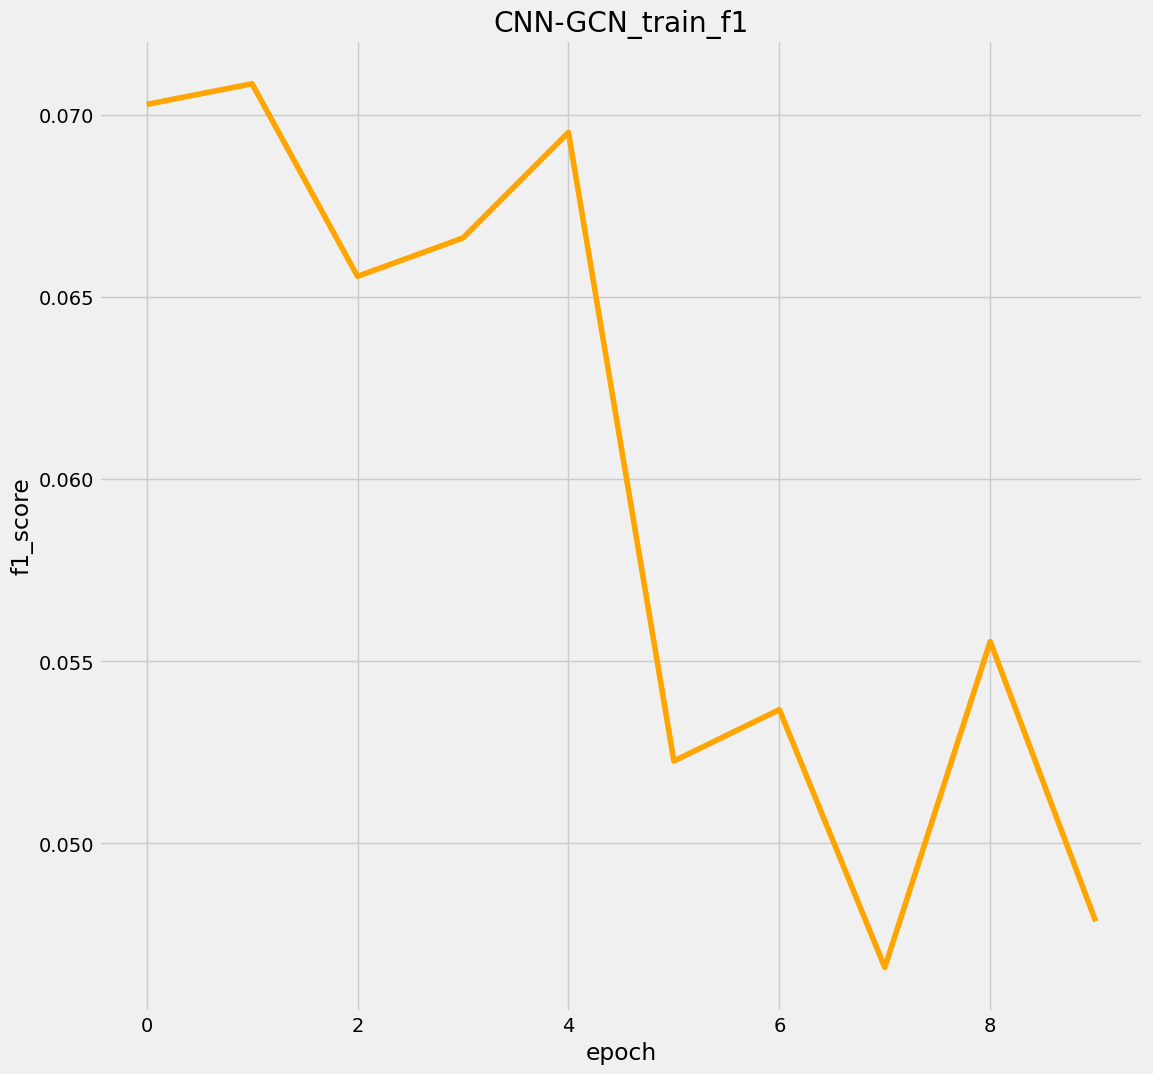

In [31]:
plt.figure(figsize=(12, 12))
x = range(len(train_f1_2))
y = train_f1_2
plt.plot(x, y, color='orange')
plt.xlabel('epoch')
plt.ylabel('f1_score')
plt.title('CNN-GCN_train_f1')
plt.show()

In [ ]:
model_path = './models/'
torch.save(model_cnngcn.state_dict(), model_path + 'CNN-GCN-epoch100.pt')

In [ ]:
import pickle
with open("cnn-gcn_train_loss.pickle", "wb") as f:
    pickle.dump(train_loss_2, f)
with open("cnn-gcn_train_precision.pickle", "wb") as f:
    pickle.dump(train_precision_2, f)
with open("cnn-gcn_train_recall.pickle", "wb") as f:
    pickle.dump(train_recall_2, f)
with open("cnn-gcn_train_f1s.pickle", "wb") as f:
    pickle.dump(train_f1_2, f)

with open("cnn-gcn_val_loss.pickle", "wb") as f:
    pickle.dump(val_loss_2, f)
with open("cnn-gcn_val_precision.pickle", "wb") as f:
    pickle.dump(val_precision_2, f)
with open("cnn-gcn_val_recall.pickle", "wb") as f:
    pickle.dump(val_recall_2, f)
with open("cnn-gcn_val_f1s.pickle", "wb") as f:
    pickle.dump(val_f1_2, f)


In [ ]:
# model_resnet_epoch30 = Resnet50(N_LABEL).to(device)
# model_resnet_epoch30.load_state_dict(
#     torch.load('./models/resnet50-epoch30.pt'))
# criterion = nn.MultiLabelSoftMarginLoss()

# test_loader, test_total_batch = get_dataloader(
#     X_test, y_test_bin, 32, 'test')

# model_resnet_epoch30.eval()
# test_running_loss = 0.0
# test_total_predictions = []
# test_total_labels = []

# for test_inputs, test_labels in test_loader:
#     test_inputs = test_inputs.to(device)
#     test_labels = test_labels.to(device)

#     # 모델에 입력값 전달
#     test_outputs = model_resnet_epoch30(test_inputs)

#     # 손실 계산
#     test_loss = criterion(test_outputs, test_labels)

#     # 예측값 계산
#     test_prediction = torch.sigmoid(test_outputs) >= 0.5

#     # 정확도 계산
#     test_running_loss += test_loss.item() * test_inputs.size(0)
#     test_total_predictions += test_prediction.tolist()
#     test_total_labels += test_labels.tolist()

# test_epoch_loss = test_running_loss / len(test_loader.dataset)
# test_precision, test_recall, test_f1_score = multi_label_metrics(
#     torch.tensor(test_total_labels), torch.tensor(test_total_predictions))
# print(test_epoch_loss, test_precision, test_recall, test_f1_score)


In [ ]:
# plt.figure(figsize=(12, 12))
# x = range(30)
# y = [0.0311, 0.0415, 0.0307, 0.0354, 0.0270,
#      0.0275, 0.0291, 0.0235, 0.0233, 0.0233, 0.0233, 0.0233, 0.0234, 0.0241, 0.0242, 0.0245, 0.0244, 0.0241, 0.0247, 0.0250, 0.0243, 0.0247, 0.0246, 0.0247, 0.0243, 0.0245, 0.0247, 0.0248, 0.0247,0.0245]
# plt.plot(x, y)
# plt.xlabel('epoch')
# plt.ylabel('loss')
# plt.title('validation_loss')
# plt.show()


In [ ]:
# plt.figure(figsize=(12, 12))
# x = range(30)
# y = [0.1001, 0.1029, 0.1854, 0.1751, 0.2364,
#      0.2443, 0.2380, 0.3363, 0.3332, 0.3415, 0.3470, 0.3570, 0.3606, 0.3543, 0.3503, 0.3555, 0.3577, 0.3600, 0.3624, 0.3512, 0.3577, 0.3553, 0.3610, 0.3566, 0.3589, 0.3599, 0.3542, 0.3596, 0.3680, 0.3596, ]
# plt.plot(x, y, color='red')
# plt.xlabel('epoch')
# plt.ylabel('precision')
# plt.title('validation_precision')
# plt.show()


In [ ]:
# plt.figure(figsize=(12, 12))
# x = range(30)
# y = [0.0279, 0.0301, 0.0709, 0.0615, 0.1038,
#      0.1053, 0.0935, 0.1470, 0.1444, 0.1500, 0.1657, 0.1677, 0.1713, 0.1671, 0.1692, 0.1652, 0.1663, 0.1723, 0.1657, 0.1620, 0.1710, 0.1688, 0.1691, 0.1697, 0.1734, 0.1702, 0.1640, 0.1658, 0.1723, 0.1715, ]
# plt.plot(x, y, color='green')
# plt.xlabel('epoch')
# plt.ylabel('recall')
# plt.title('validation_recall')
# plt.show()


In [ ]:
# plt.figure(figsize=(12, 12))
# x = range(30)
# y = [0.0437, 0.0466, 0.1026, 0.0910, 0.1443,
#      0.1472, 0.1343, 0.2046, 0.2015, 0.2084, 0.2243, 0.2282, 0.2323, 0.2271, 0.2282, 0.2256, 0.2270, 0.2331, 0.2274, 0.2217, 0.2314, 0.2289, 0.2304, 0.2299, 0.2338, 0.2311, 0.2242, 0.2269, 0.2347, 0.2322]
# plt.plot(x, y, color='orange')
# plt.xlabel('epoch')
# plt.ylabel('f1_score')
# plt.title('validation_f1')
# plt.show()


In [ ]:
# model_path = './models/'
# pytorch_model = Resnet50(333)
# pytorch_model.load_state_dict(torch.load('./models/resnet50-epoch30.pt'))
# pytorch_model.eval()
# dummy_input = torch.zeros(1, 3, 224, 224)
# torch.onnx.export(pytorch_model, dummy_input,
#                   './models/resnet50_model.onnx', verbose=True, opset_version=10)
